In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from torch import nn

### Setting up the geometry

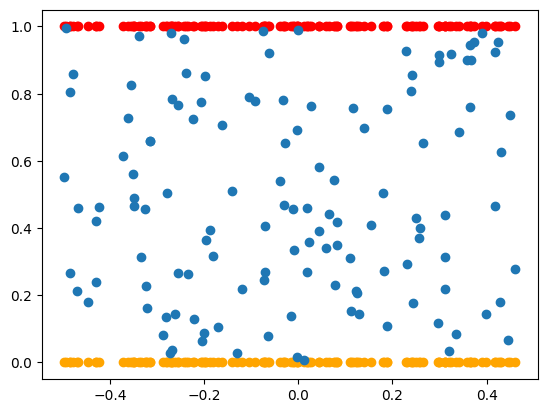

In [3]:
#Cloud Generator

domain_X = [-.5, .5]
domain_Y = [0, 1]

rng = np.random.default_rng(123)

def cloud(size=128):
  
  #interior
  X = rng.uniform(domain_X[0], domain_X[1], size)
  Y = rng.uniform(domain_Y[0], domain_Y[1], size)

  return (X, Y)

#Random Plotting in Domain
x, y = cloud(128)
plt.scatter(x, np.zeros_like(x), color='orange')
plt.scatter(x, np.ones_like(x), color='red')
plt.scatter(x, y)
plt.show()

In [5]:
class NSFnet_VP(nn.Module):
  def __init__(self):
    super().__init__()

    self.FC1 = nn.Linear(2, 64)
    self.AC1 = nn.Tanh()

    self.FC2 = nn.Linear(64, 128)
    self.AC2 = nn.Tanh()

    self.FC3 = nn.Linear(128, 2)

  def forward(self, x):
    out = self.AC1(self.FC1(x))
    out = self.AC2(self.FC2(out))
    out = self.FC3(out)
    return out

In [8]:
model = NSFnet_VP()
lr=0.01
optimizer = torch.optim.Adam(model.parameters(), lr)
epochs = 1000

In [11]:
for epoch in tqdm(range(epochs)):

  #Data
  size = 128
  x_sample, y_sample = cloud(size)
  x_t = torch.tensor(x_sample, dtype=torch.float, requires_grad=True)
  y_t = torch.tensor(y_sample, dtype=torch.float, requires_grad=True)
  data = torch.stack([torch.cat([x_t, x_t, x_t], dim=0), torch.cat([y_t, torch.ones_like(y_t), torch.zeros_like(y_t)])], dim=1)

  
  #PDE Predictions
  preds = model(data)
  u_preds = preds[:size, 0]#Velocity
  p_preds = preds[:size, 1]#Pressure

  
  #Differentials
  du_dx = torch.autograd.grad(u_preds, x_t, torch.ones_like(u_preds), create_graph=True, retain_graph=True)[0]
  du_dy = torch.autograd.grad(u_preds, y_t, torch.ones_like(u_preds), create_graph=True, retain_graph=True)[0]
  d2u_dy2 = torch.autograd.grad(du_dy, y_t, torch.ones_like(u_preds), create_graph=True, retain_graph=True)[0]

  dp_dx = torch.autograd.grad(p_preds, x_t, torch.ones_like(p_preds), create_graph=True, retain_graph=True)[0]
  dp_dy = torch.autograd.grad(p_preds, y_t, torch.ones_like(p_preds), create_graph=True, retain_graph=True)[0]

  #Losses
  mu = 1

  #PDE_Loss
  loss = torch.sum(du_dx**2)
  loss = loss + torch.sum(dp_dy**2)
  loss = loss + torch.sum((dp_dx-100)**2)
  loss = loss + torch.sum((dp_dx-mu*(d2u_dy2))**2)
  loss_p = loss

  #Boundary Loss
  v = -5
  loss = torch.sum((preds[size:size*2,0]-v)**2)
  loss = loss+torch.sum((preds[size*2:size*3,0])**2)
  loss_b = loss

  alpha_b = 0.01

  #Total loss
  loss = loss_p + alpha_b*loss_b 

  if(epoch%100==0 or epoch==999):
    print("PDE Loss:", loss_p.item(), ", Boundary Loss:", loss_b.item())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  2%|▏         | 24/1000 [00:00<00:08, 120.12it/s]

PDE Loss: 110.86848449707031 , Boundary Loss: 0.6015893816947937


 12%|█▏        | 117/1000 [00:00<00:06, 128.54it/s]

PDE Loss: 116.98587036132812 , Boundary Loss: 5.751428127288818


 21%|██        | 210/1000 [00:01<00:06, 116.74it/s]

PDE Loss: 225.78695678710938 , Boundary Loss: 1.4206806421279907


 31%|███▏      | 314/1000 [00:02<00:05, 124.90it/s]

PDE Loss: 34.84730911254883 , Boundary Loss: 13.980243682861328


 42%|████▏     | 418/1000 [00:03<00:04, 121.51it/s]

PDE Loss: 197.66119384765625 , Boundary Loss: 17.037845611572266


 53%|█████▎    | 526/1000 [00:04<00:03, 127.83it/s]

PDE Loss: 238.91207885742188 , Boundary Loss: 410.1302185058594


 62%|██████▏   | 617/1000 [00:05<00:03, 120.79it/s]

PDE Loss: 16.109756469726562 , Boundary Loss: 7.968112945556641


 72%|███████▏  | 720/1000 [00:05<00:02, 123.84it/s]

PDE Loss: 259.486572265625 , Boundary Loss: 4.986677646636963


 82%|████████▏ | 823/1000 [00:06<00:01, 124.09it/s]

PDE Loss: 900.0157470703125 , Boundary Loss: 27.039113998413086


 92%|█████████▏| 915/1000 [00:07<00:00, 125.13it/s]

PDE Loss: 12.721022605895996 , Boundary Loss: 0.7085955739021301


100%|██████████| 1000/1000 [00:08<00:00, 121.63it/s]

PDE Loss: 56.14611053466797 , Boundary Loss: 0.12158185243606567


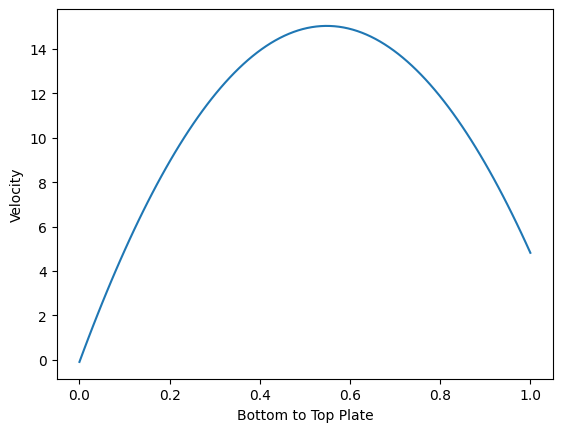

In [13]:
#Plotting Results

y = np.linspace(domain_Y[0], domain_Y[1], 100)
x = np.zeros_like(y)

x_t = torch.tensor(x, dtype=torch.float)
y_t = torch.tensor(y, dtype=torch.float)

with torch.no_grad():
  preds = model(torch.stack([x_t, y_t], dim=1))

u_preds = preds[:, 0].numpy()
p_preds = preds[:, 1].numpy()

plt.plot(y, -u_preds,)
plt.xlabel('Bottom to Top Plate')
plt.ylabel('Velocity')
plt.show()

# plt.plot(y, p_preds)
# plt.xlabel('Y')
# plt.ylabel('Pressure')
# plt.show()